# 2. Static Maps in Python

# Part I: Basic Maps

In this session, we will use the libraries `matplotlib` and `contextily` to plot the information represented into different `GeoDataFrames`. 
We will look into plotting `Point`, `LineString` and `Polygon` `GeoDataFrames`. Most of the plots here are rather ugly but, at this point, the goal is to get familiar with the parameters of the plot function and what can be done with them.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import osmnx as ox
import contextily as ctx
import seaborn as sns

## 2.1 Plotting Points

Load the data of terrorist attacks 1970-2020 and choose a country. Germany is used as a case study here but feel free to change the country.
If you do so, also change the `crs` (see https://epsg.io).

In [2]:
attacks = pd.read_csv("data/GTD_2022.csv", low_memory = False)

Creating the `GeoDataFrame` from the `DataFrame`

In [3]:
germany = ['West Germany (FRG)', 'Germany', 'East Germany (GDR)'] # Germany was split till 1989 in two entities
df = attacks[attacks.country_txt.isin(germany)].copy()

# Uncomment the lines below for other countries that haven't changed their denominations/boundaries between 1970 and today:
# country = 'France' 
# df = attacks[attacks.country_txt == country].copy()#
wgs = 'EPSG:4326'
germany_crs = 'EPSG:4839'
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = wgs)
gdf = gdf[~gdf.geometry.is_empty] # remove empty geometries
gdf.to_file("data/germany.shp")
gdf = gdf.to_crs(germany_crs)

C:\Users\gfilo\AppData\Local\Temp\ipykernel_700\3815068564.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("data/germany.shp")


Basic plotting

<Axes: >

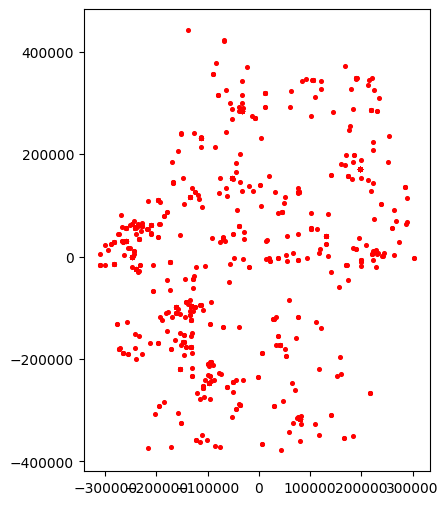

In [4]:
# prepare the axis and coordinate
nr_rows = 1
nr_cols = 1
fig, ax = plt.subplots(nr_cols, nr_rows, figsize=(8, 6))
gdf.plot(ax=ax, color='red', markersize=7)

#### Slightly improving the plot

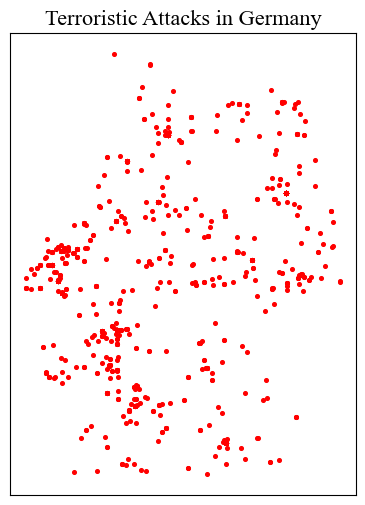

In [5]:
# removing ticks
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.tick_params(axis= 'both', which= 'both', length=0)
title_parameters = {'fontsize':'16', 'fontname':'Times New Roman'}
ax.set_title("Terroristic Attacks in Germany", **title_parameters)
fig

### Adding some context: Base Maps with `Contextily`
see providers and options here https://xyzservices.readthedocs.io/en/stable/introduction.html

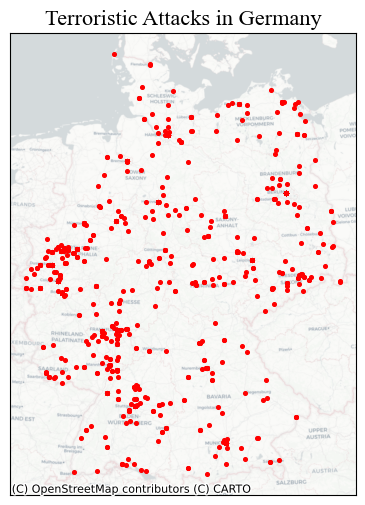

<Figure size 640x480 with 0 Axes>

In [6]:
source = ctx.providers.CartoDB.Positron
ctx.add_basemap(ax, crs= gdf.crs.to_string(), source= source)
# replot
fig

### Parameters specific to `Point` in the `plot` method 
- `markersize`: numerical value (for now)
- `marker`: see https://matplotlib.org/stable/api/markers_api.html

#### Other properties, shape independent:
- `color`: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
- `alpha`: regulates transparency of the shape: 0 to 1

In [7]:
# first, let's make a function

def ax_ticks_off(ax):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.tick_params(axis= 'both', which= 'both', length=0)

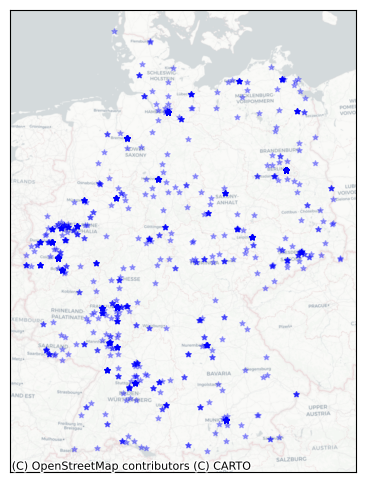

In [8]:
# prepare the axis and coordinate
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf.plot(ax=ax, markersize = 15, color = 'blue', marker = '*', alpha = 0.3)
ctx.add_basemap(ax, crs= gdf.crs.to_string(), source= source)
ax_ticks_off(ax)

## 2.2 Plotting LineStrings
Let's import railway tracks in the Western Balkans (Slovenia, Croatia, Bosnia & Herzegovina, Montenegro, Serbia, Kosovo)

<Axes: >

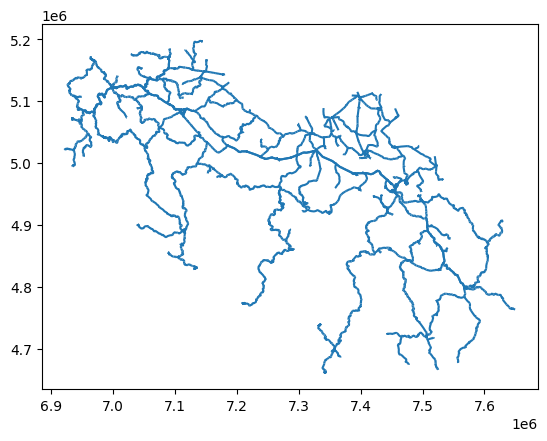

In [9]:
wb_crs = 'EPSG:31277'
lines_gdf = gpd.read_file("data\wb_railways.shp")
lines_gdf.plot()

Text(0.5, 1.0, 'Railway infrastructure in the West Balkans')

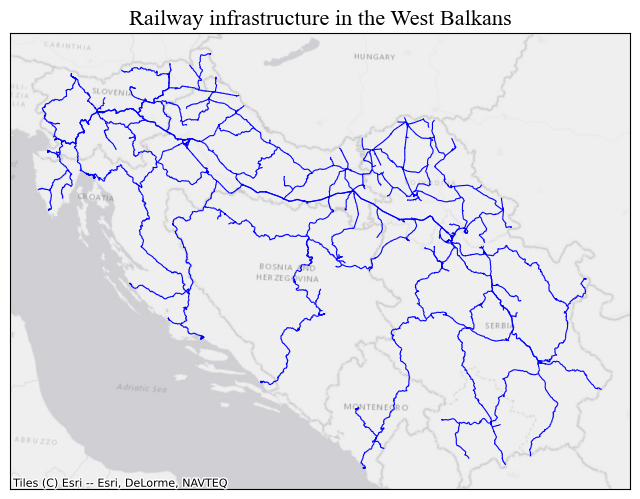

In [10]:
# prepare the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
lines_gdf.plot(ax=ax, linewidth = 0.8, color = 'blue', alpha = 1)
ctx.add_basemap(ax, crs= lines_gdf.crs.to_string(), source = ctx.providers.Esri.WorldGrayCanvas)
ax_ticks_off(ax)
ax.set_title("Railway infrastructure in the West Balkans", **title_parameters) #parameters as above

One can also filter prior to plotting, based on the columns in the GeoDataFrame. First we download Serbia's Boundary with `OSMNX`, more on that later on. Then we filter `lines_gdf` with a `within` operation.

In [11]:
serbia = ox.geocode_to_gdf('Serbia')
serbia = serbia.to_crs(wb_crs)
serbia_lines = lines_gdf[lines_gdf.geometry.within(serbia.iloc[0].geometry)].copy() #there's only one polygon in the gdf

Text(0.5, 1.0, 'Railway infrastructure in Serbia and Kosovo')

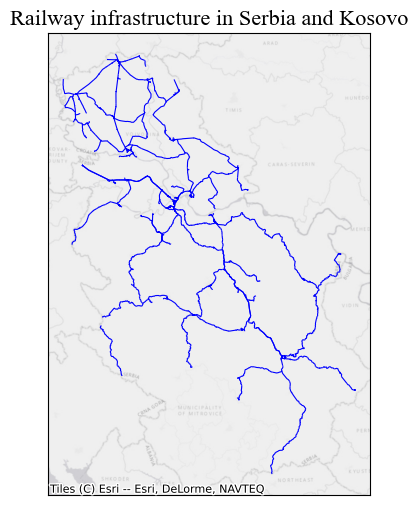

In [12]:
# prepare the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
serbia_lines.plot(ax=ax, linewidth = 0.8, color = 'blue', alpha = 1)
ctx.add_basemap(ax, crs= lines_gdf.crs.to_string(), source = ctx.providers.Esri.WorldGrayCanvas)
ax_ticks_off(ax)
ax.set_title("Railway infrastructure in Serbia and Kosovo", **title_parameters) #parameters as above

### Parameters specific to `LineString`: 
- `linewidth`: numerical value (for now).
- `capstyle`: controls how Matplotlib draws the corners where two different line segments meet. See https://matplotlib.org/stable/gallery/lines_bars_and_markers/capstyle.html
- `joinstyle`': controls how Matplotlib draws the corners where two different line segments meet. https://matplotlib.org/stable/gallery/lines_bars_and_markers/joinstyle.html

Text(0.5, 1.0, 'Railway infrastructure in Serbia')

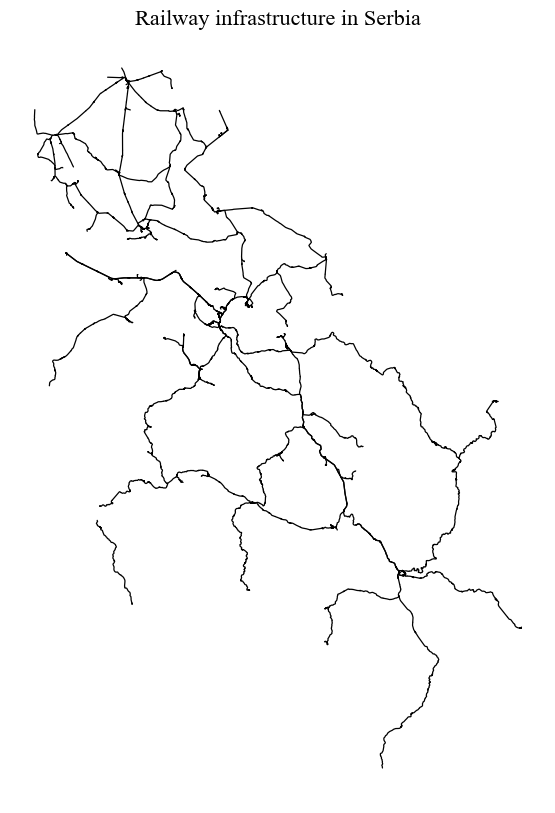

In [13]:
# prepare the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
serbia_lines.plot(ax=ax, linewidth = 0.9, color = 'black', alpha = 1, capstyle = 'round', joinstyle = 'round')
ax.set_axis_off() # we don't need the ticks function
ax.set_title("Railway infrastructure in Serbia", **title_parameters) #parameters as above

## 2.3 Plotting Polygons
We are again using `OSMNX` to download data from `OpenStreetMap` automatically. In this case, we will get building footprints from the city of Algiers in Alageria.

### Parameter specific to `Polygon`: 
- `edgecolor`: the outline of the polygon, by default = `None` (often better).
- `linewidth`: the width of the outline of the polygon.

In [14]:
algeria_crs = 'EPSG:30729'
tags = {"building": True} #OSM tags
buildings = ox.features_from_address("Algiers, Algeria", tags = tags, dist = 2000) 
buildings = buildings.reset_index()
 # sometimes building footprints are represented by Points, let's disregard them
buildings = buildings[(buildings.geometry.geom_type == 'Polygon') | (buildings.geometry.geom_type == 'MultiPolygon')]
buildings = buildings.to_crs(algeria_crs)

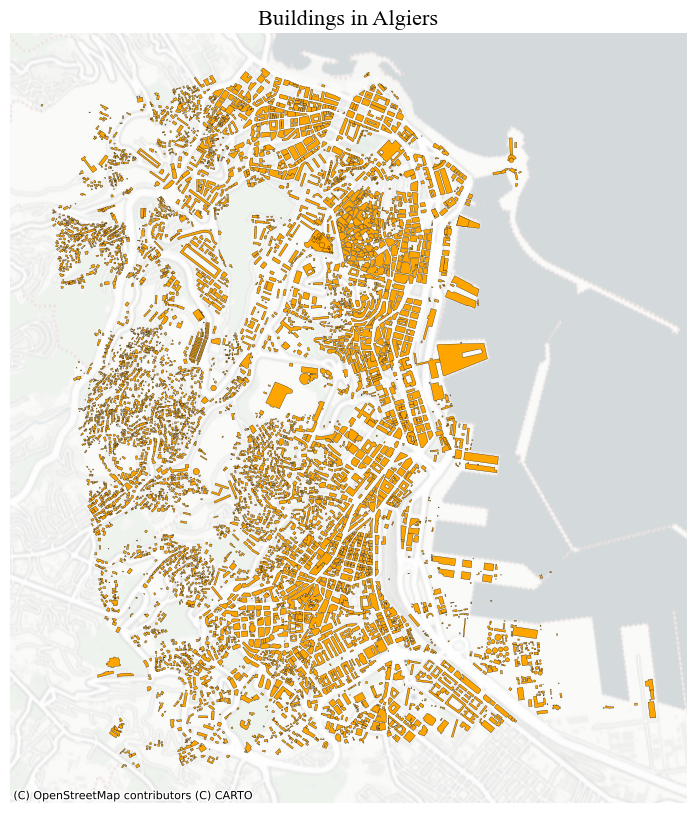

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title("Buildings in Algiers", **title_parameters)
ax.set_axis_off() # we don't need the ticks function
buildings.plot(ax=ax, color = 'orange', edgecolor = 'black', lw = 0.2)
source = ctx.providers.CartoDB.PositronNoLabels
ctx.add_basemap(ax, crs= buildings.crs.to_string(), source= source)

For polygons, you can also plot just the boundaries of the geometries by:

<Axes: >

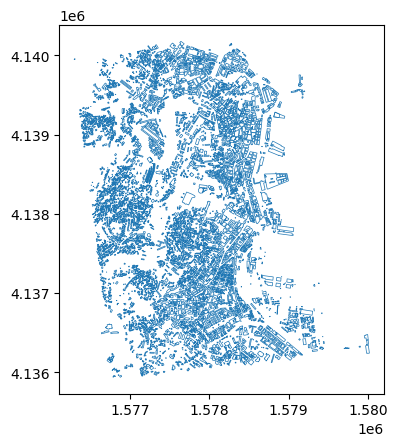

In [16]:
buildings.boundary.plot(lw = 0.5)

## 2.4 Plotting more than one layer together
Let's also download roads for Algiers

In [17]:
tags = {"highway": True} #OSM tags
roads = ox.features_from_address("Algiers, Algeria", tags = tags, dist = 2000) 
roads = roads.reset_index()
roads = roads.to_crs(algeria_crs)
 # sometimes building footprints are represented by Points, let's disregard them
roads = roads[roads.geometry.geom_type == 'LineString']

And plot everything togehter. It's important to keep in mind that the last layer is always rendered on top of the others. In other words, they may cover the previous ones.

However, you can prevent this by passing arguments to the parameter `zorder` in the `plot` method. The layer with the higher zorder value will be plotted on top. 

<Axes: title={'center': 'Buildings and Roads in Algiers'}>

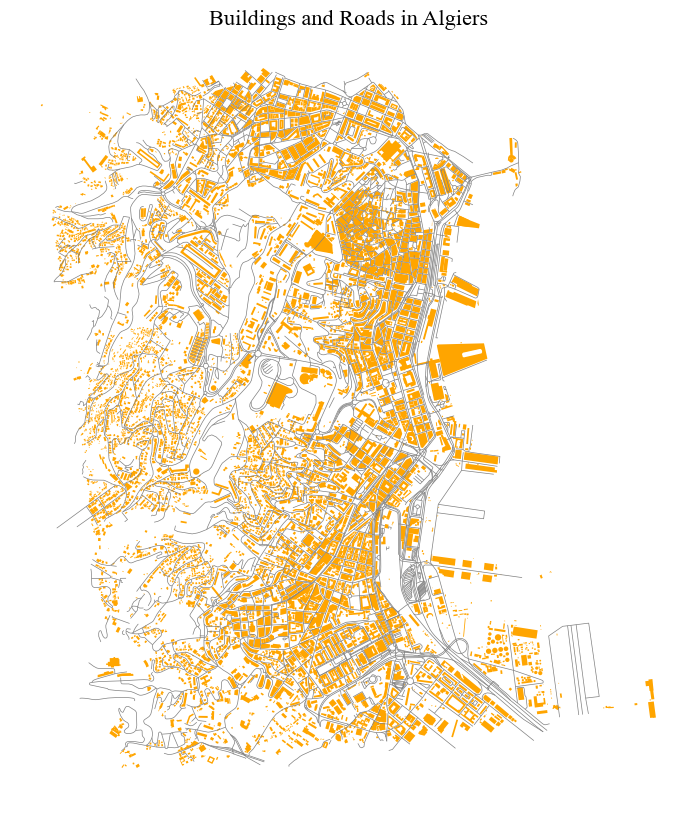

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title("Buildings and Roads in Algiers", **title_parameters)
ax.set_axis_off() # we don't need the ticks function
# only roads within the extent of the buildings layer
roads[roads.geometry.within(buildings.unary_union.envelope)].plot(ax=ax, color = 'grey', lw = 0.5) #linewidth can be also passed as lw 
buildings.plot(ax=ax, color = 'orange')

## 2.5 Sub-plots
To obtain multiple sub-plots, we manipulate the `nrows`, `ncols` parameters. We can use this approach to:
* Plot the same layer with different properties.

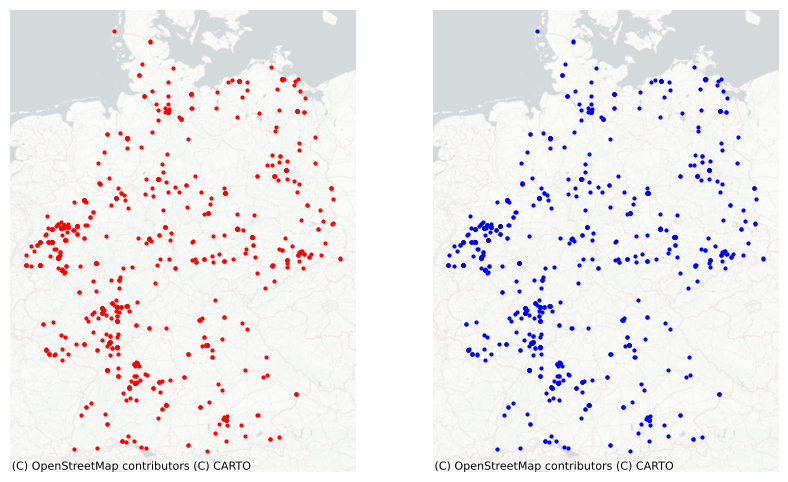

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
colors = ['red', 'blue']

for n, ax in enumerate(axes):
    gdf.plot(ax=ax, markersize = 4, color = colors[n])
    ax.set_axis_off()
    ctx.add_basemap(ax, crs= gdf.crs.to_string(), source= source)

* Plot different layers.

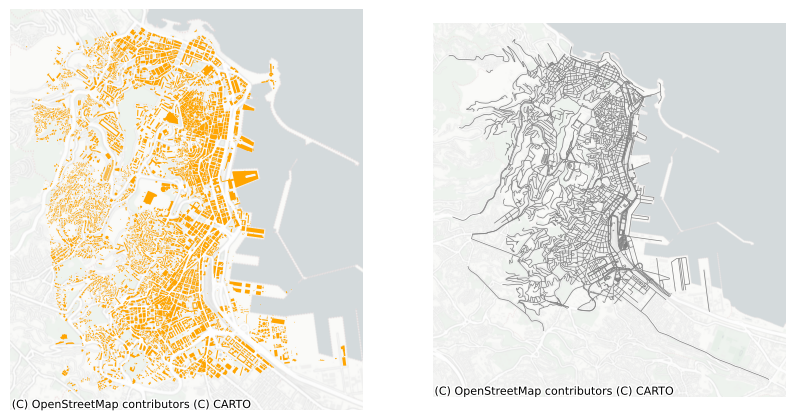

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
gdfs = [buildings, roads]
colors = ['orange', 'grey']

buildings.plot(ax=axes[0], color = 'orange', edgecolor = 'none')
roads.plot(ax=axes[1], color = 'gray', lw = 0.5)

for ax in axes:
    ax.set_axis_off()
    ctx.add_basemap(ax, crs= buildings.crs.to_string(), source = source)

* Analyse phenomena across different geographical areas. For example, terrorism in Germany and in the UK.

In [21]:
# let's prepare the gdf for the UK
df_uk = attacks[attacks.country_txt == 'United Kingdom'].copy()
uk_crs = 'EPSG:27700'
gdf_uk = gpd.GeoDataFrame(df_uk, geometry=gpd.points_from_xy(df_uk.longitude, df_uk.latitude), crs = wgs)
gdf_uk = gdf_uk.to_crs(uk_crs)

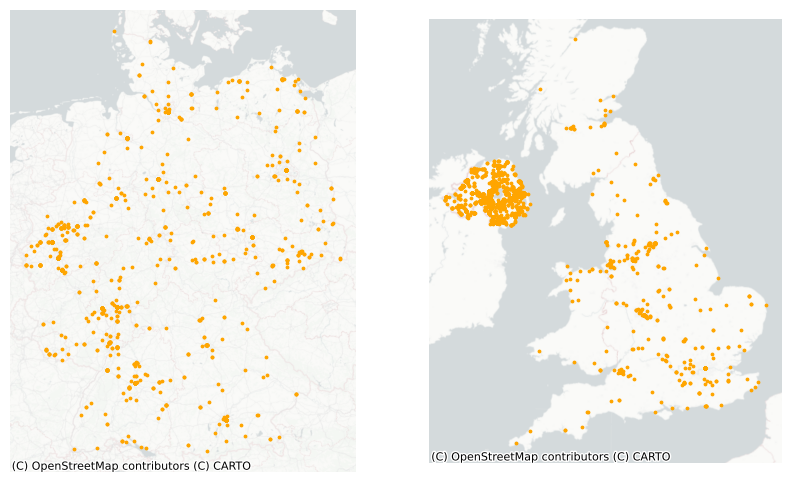

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
gdfs = [gdf, gdf_uk]

for n, ax in enumerate(axes):
    gdf_tmp = gdfs[n]
    gdf_tmp.plot(ax=ax, color = 'orange', markersize = 3)
    ax.set_axis_off()
    ctx.add_basemap(ax, crs= gdf_tmp.crs.to_string(), source= source)

<div class="alert alert-success">

**Exercise**:

* Think about the plots above and how they could be improved. 
* Copy and paste the code and execute the functions playing with the different parameters.
* Produce a neat map using the GeoDataFrames avaible in this notebook or the ones employed in the previous sessions, making use of the elements/parameters discussed here.
* Try out different tiles for the basemap to familiarise yourself with what's aveilable.
    
</div>

# Part II: Choropleth Mapping

In [23]:
import geoplot.crs as gcrs
import geoplot as gplt

## Data

For this second part of the tutorial, we will use some data at the municipality level for Serbia. The data contains information regarding poverty level, average income, population and tourism. The data is taken from https://data.stat.gov.rs/?caller=SDDB&languageCode=en-US and can be associated to the polygons representing the administrative boundaries of the municipalities. These boundaries can be found here https://data.humdata.org/dataset/geoboundaries-admin-boundaries-for-serbia?force_layout=desktop.
While most of the data refers to 2023, the admin boundaries file traces back to 2017. Thus, it may contain obsolete information (few changes may occur).

Later on, we will go back to the terrorism dataset.

In [24]:
# This will be different on your computer and will depend on where
# you have downloaded the files
serbia_crs = 'EPSG:31277'
wgs = 'EPSG:4326'
serbia_admin = gpd.read_file('data/serbia_admin.shp')
serbia_admin.set_index('townID', inplace = True, drop = True)
serbia_admin = serbia_admin.to_crs(serbia_crs)

Let's plot the `GeoDataFrame` following the last session's steps.

Text(0.5, 1.0, 'Serbian Municipalities')

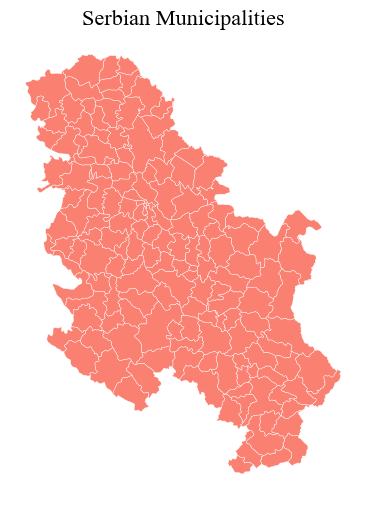

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
serbia_admin.plot(ax = ax, color = 'salmon', linewidth = 0.3, edgecolor = 'white')
ax.set_axis_off()
title_parameters = {'fontsize':'16', 'fontname':'Times New Roman'}
ax.set_title("Serbian Municipalities", **title_parameters) #parameters as above

The we load the data and merge it into the `GeoDataFrame`, before getting rid of municipalities that do not have a corresponding shape/record in the GeoDataFrame (probably the result of changes in the national subdivisions).

In [26]:
data = pd.read_csv("data/serbia_data.csv") #some slavic characters 
data.drop('name_en', axis = 1, inplace = True)
serbia_admin = pd.merge(serbia_admin, data, left_on = "townID", right_on = "id")
serbia_admin = serbia_admin[serbia_admin.id.notna()]
serbia_admin['id'] = serbia_admin['id'].astype('int64')
serbia_admin.head()

#let's save the so-obtained gdf for later (encoding for dealing with slavic characters).
serbia_admin.to_file("data/serbia_data.shp", encoding='utf-8')

Creating a choropleth map is rather straightforward and can ben done by using few other parameters. Reflect on what you see and whether the map below is informative.

Text(0.5, 1.0, 'Serbian Municipalities')

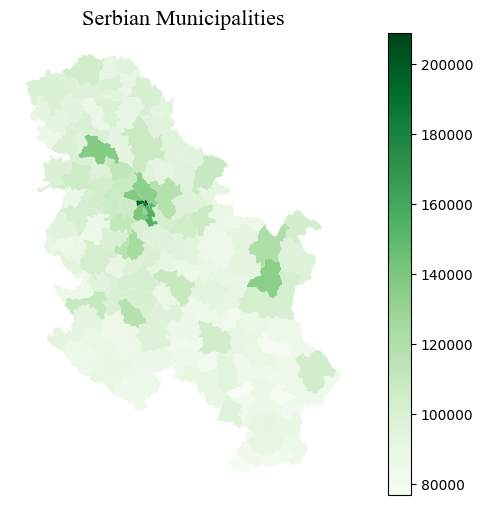

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
serbia_admin.plot(ax = ax, column = 'gross', linewidth = 0.3, cmap = 'Greens', legend = True)
ax.set_axis_off()
title_parameters = {'fontsize':'16', 'fontname':'Times New Roman'}
ax.set_title("Serbian Municipalities", **title_parameters) #parameters as above

## 2.6 Choropleth Maps for Numerical Variables
We are essentialy using the same approach emplyed for creating basic maps, the method `plot`, but we now need to pass arguments to some new parameters to specify which column is to be represented and how. As an optional argument, one can set legend to `True` and the resulting figure will include a color bar.

- `column`: the name of the column representing the variable that we want to used to colour-code our shapes.
- `scheme`: the scheme used to color the shapes based on the variable values.
- `cmap`: the colormap used to show variation.

#### Colormaps

Built-in color maps can be found here https://matplotlib.org/stable/gallery/color/colormap_reference.html.
However one can create new ones as follows from a list of colours:

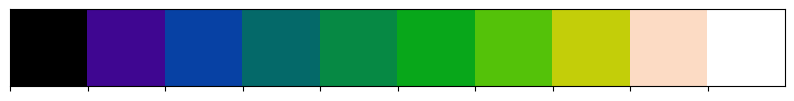

In [28]:
from seaborn import palplot
from matplotlib.colors import LinearSegmentedColormap

colors = [(0.00, 0.00, 0.00,1), (0.248, 0.0271, 0.569, 1), (0.0311, 0.258, 0.646,1),
            (0.019, 0.415, 0.415,1), (0.025, 0.538, 0.269,1), (0.0315, 0.658, 0.103,1),
            (0.331, 0.761, 0.036,1),(0.768, 0.809, 0.039,1), (0.989, 0.862, 0.772,1),
            (1.0, 1.0, 1.0)]
palplot(colors)

In [29]:
kindlmann = LinearSegmentedColormap.from_list('kindlmann', colors)

or from color names: 

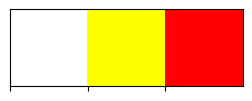

In [30]:
colors = ["white", "yellow", "red"]
palplot(colors)

Let's try a new colormap and let's also set a number of classes to divide the data in, through the parameter `k`.

In [31]:
white_to_red = LinearSegmentedColormap.from_list("name", ["yellow","red"])

Text(0.5, 1.0, 'Serbian Municipalities')

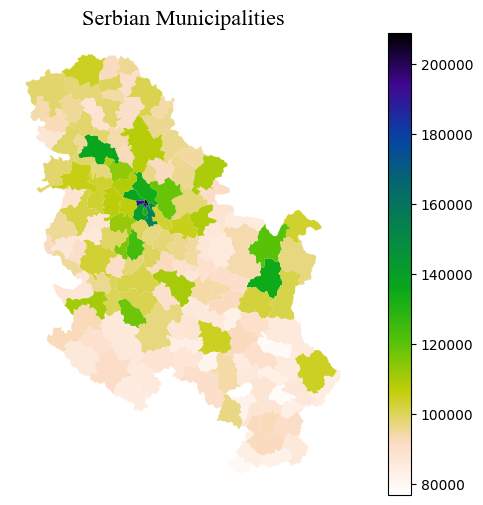

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
serbia_admin.plot(ax = ax, column = 'gross', linewidth = 0.3, cmap = kindlmann.reversed(), legend = True, k = 8)
ax.set_axis_off()
title_parameters = {'fontsize':'16', 'fontname':'Times New Roman'}
ax.set_title("Serbian Municipalities", **title_parameters) #parameters as above

With `GeoPandas`, when you use the `plot` method with `legend=True` the type of legend that appears depends on the data being visualized:

- Continuous Data: For columns with continuous data (like population estimates, temperatures, etc.), a color bar is generated as the legend. This color bar represents a range of values with a gradient, indicating how data values correspond to colors on the map.
- Categorical Data: For columns with categorical data (like country names, types of land use, etc.), if you specify `legend=True`, `GeoPandas` will try to create a legend that categorizes these distinct values with different colors. However, creating legends for categorical data is not as straightforward as with continuous data and might require additional handling for a clear and informative legend (see below).

#### Scheme
It is important to keep in mind that choropleth maps strongly depend on the scheme that it is passed (or the dafult one) to classify the data in groups.
The plot above only shows one municipality cooloured in dark blue.

Look at the following plots and how three different classifiers produce different results for the same data.

Refer to https://geopandas.org/en/stable/gallery/choropleths.html 
and https://geographicdata.science/book/notebooks/05_choropleth.html for further details

In [33]:
# Function for plotting the map and the distribution of the value in bins  

from mapclassify import Quantiles, EqualInterval, FisherJenks

def plot_scheme(gdf, column, scheme, figsize=(10, 6)):
    '''
    Arguments
    ---------
    gdf: GeoDataFrame
        The GeoDataFrame to plot
    column: str
        Variable name 
    scheme: str
        Name of the classification scheme to use 
    figsize: Tuple
        [Optional. Default = (10, 6)] Size of the figure to be created.

    '''
    schemes = {'equal_interval': EqualInterval, 'quantiles': Quantiles, 'fisher_jenks': FisherJenks} 
    classification = schemes[scheme](gdf[column], k=7)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    # KDE
    sns.kdeplot(gdf[column], fill=True, color='purple', ax=ax1)
    sns.rugplot(gdf[column], alpha=0.5, color='purple', ax=ax1)
    for cut in classification.bins:
        ax1.axvline(cut, color='blue', linewidth=0.75)
    ax1.set_title('Value distribution')
    # Map
    p = gdf.plot(column=column, scheme=scheme, alpha=0.75, k=7, cmap='RdPu', ax=ax2, linewidth=0.1)
    ax2.axis('equal')
    ax2.set_axis_off()
    ax2.set_title('Geographical distribution')
    fig.suptitle(scheme, size=25)
    plt.show()

- *Equal intervals* splits the range of the distribution, the difference between the minimum and maximum value, into equally large segments and to assign a different color to each of them according to a palette that reflects the fact that values are ordered.
- To obtain a more balanced classification, one can use the *Quantiles* scheme. This assigns the same amount of values to each bin: the entire series is laid out in order and break points are assigned in a way that leaves exactly the same amount of observations between each of them. This "observation-based" approach contrasts with the "value-based" method of equal intervals and, although it can obscure the magnitude of extreme values, it can be more informative in cases with skewed distributions.
- Amongst many other, the *Fisher Jenks* dynamically minimises the sum of the absolute deviations around class medians. The Fisher-Jenks alorithm is guaranteed to produce an optimal classification for a prespecified number of classes.

The only additional arguments to pass for producing a choropleth, therefore, are the actual variable we would like to classify and the number of segments we want to create, `k`. This is, in other words, the number of colors that will be plotted on the map so, although having several can give more detail, at some point the marginal value of an additional one is fairly limited, given the ability of teh human brain to tell any differences.

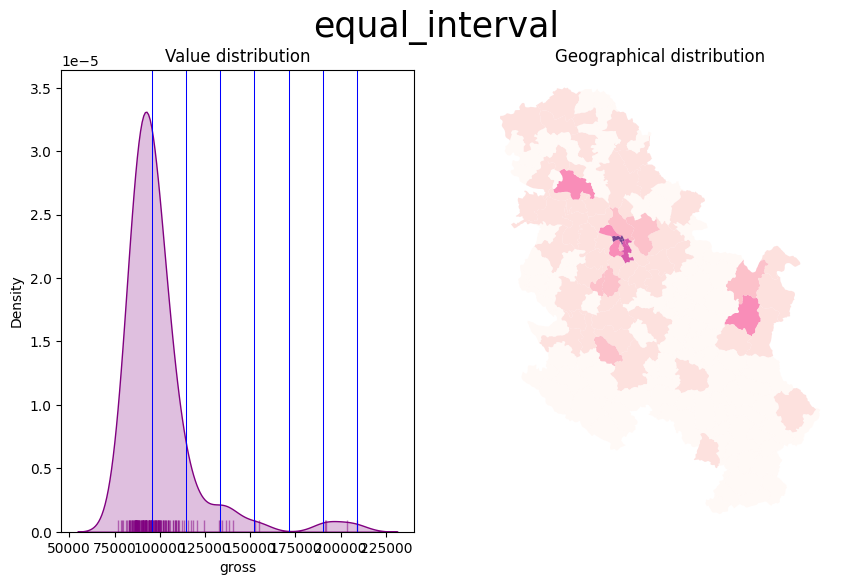

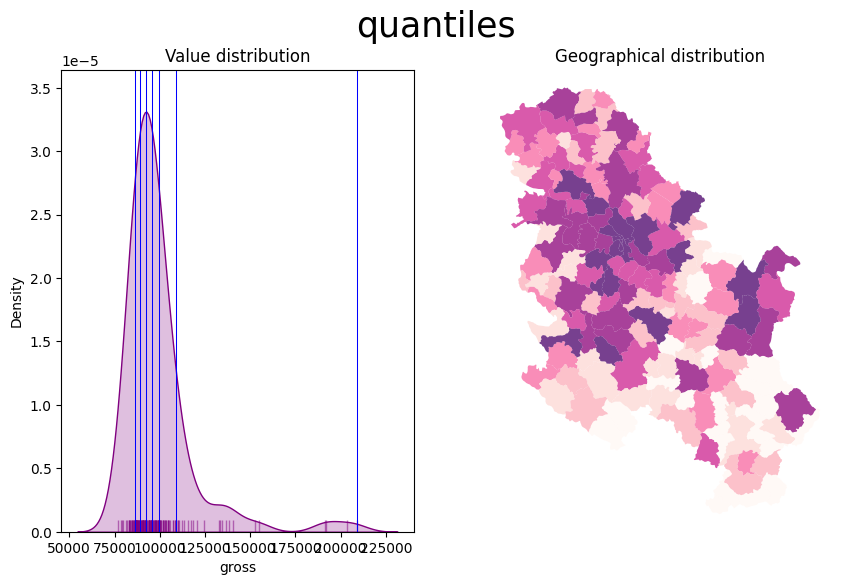

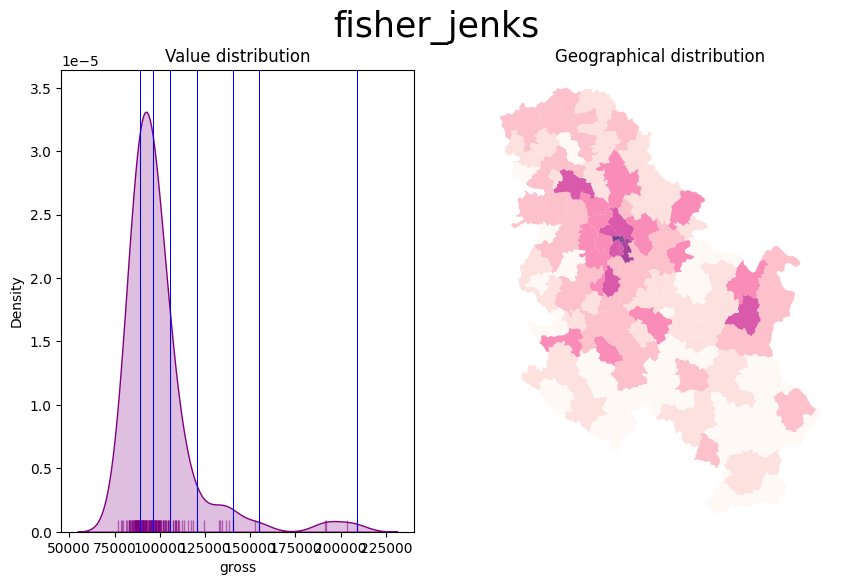

In [34]:
schemes = ['equal_interval', 'quantiles', 'fisher_jenks']
for scheme in schemes:
    plot_scheme(serbia_admin, 'gross', scheme)

Also consider the [Modifiable Areal Unit Problem](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem) and how the geographies of the administrative boundaries, in this case, may impact the visualisation.

<img src=img/MAUP.jpg/ width = 70%>

For example, the most populated area is a municipality in the north that corresponds to the city of Novi Sad. 
Let's have a look at the data

In [35]:
serbia_admin[['name', 'pop', 'Province']].sort_values(by = 'pop', ascending = False).iloc[:10]

name       pop       Province
48       Novi Sad  341625.0    Južno-Bački
24   Novi Beograd  186667.0   Grad Beograd
19       Čukarica  154854.0   Grad Beograd
3      Kragujevac  154290.0     Šumadijski
26       Palilula  148292.0   Grad Beograd
34          Zemun  143173.0   Grad Beograd
32       Voždovac  137315.0   Grad Beograd
35       Zvezdara  130225.0   Grad Beograd
39       Leskovac  123201.0     Jablanički
120      Subotica  121250.0  Severno-Bački

In our dataset, the city of Novi Sad is categorised as a municipality by itself, because the administrative boundaries file is not updated. In reality, "since 2002, when the new statute of the city of Novi Sad came into effect, Novi Sad is divided into two city municipalities, Petrovaradin and Novi Sad. From 1989 until 2002, the name Municipality of Novi Sad meant the whole territory of the present-day city of Novi Sad." (see: https://en.wikipedia.org/wiki/City_municipality_of_Novi_Sad).  

On the contrary, Grad Beograd, that is Belgrade, is correctly split into different municipalities and its popoulation, when visualised, is spread out across the different geometries of its municipalities, In other words, our map depends on the geometries of the areas and on how the data was collected. While it could be that these areas were indeed identified by population size in the first place, the point is that the fact that Novi Sad is not split into more areas, as Belgrade is, makes it stound out more clearly from the map (and to some extent a bit unfairly)

This may happen with different types of data, particularly with administrative boundaries and it is crucial to reflect on how Choropleth maps may be impacted. One can look for more granular data or consider to weight the continous value with the texent of the are (i.e. obtaining density values).

#### An alternative to scheme: ColorMap Normalisation

The `mpl.colors.Normalize` function in `matplotlib` creates a normalization object, which adjusts data values into a range that is ideal for colour mapping in a colormap. This function is particularly beneficial in scenarios where precise control over the mapping of data values to colour representations is needed.

When employed in a plotting function, this normalization object ensures that the data values are scaled to fit a pre-defined range (for instance, `norm = mpl.colors.Normalize(vmin=0, vmax=40)`). Any values falling below 0 are mapped to the lowest colour on the colormap scale, while values exceeding 40 are mapped to the highest colour. This approach is especially useful when aiming to highlight differences within a specific data range; it can significantly enhance the visualization of data, by, for example, emphasizing temperature variations between 0°C and 40°C. This becomes crucial in instances where a few data points with high values (e.g., 50°C) might otherwise lead to a less informative visualization if not 'normalized' and treated as if they corresponded to 40° C values.

For our dataset, we can use as `vmax` the value corresponding to the 90th percentle.

In [36]:
serbia_admin['pop'].quantile(0.90)

93014.0

<Axes: >

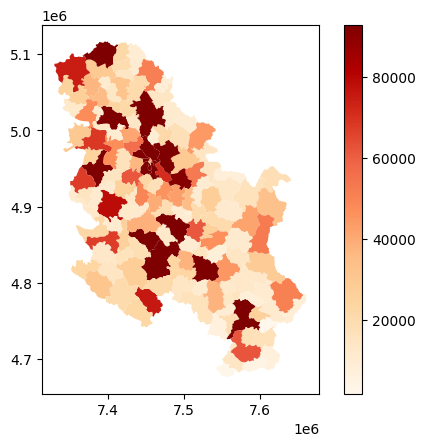

In [37]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 1)
vmin = serbia_admin['pop'].min()
vmax = serbia_admin['pop'].quantile(0.90) # 
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
serbia_admin.plot(ax = ax, column='pop', cmap='OrRd', legend=True, norm = norm)

<div class="alert alert-info" style="font-size:120%">

**Important**: <br>

When passing `norm` in the `plot` method, do not pass the arguments to the `scheme` parameter. For continuous variables, `norm` maps each value directly to a color, making discrete categorization redundant. In other words, it allows for a direct mapping of data values to the color map, eliminating the need for intermediary classification schemes.`norm` ensures a smooth gradient in the color map without artificially segmenting the data.


#### Customising the colorbar

[Text(1, 1561.0, '1561.0'), Text(1, 93014.0, '>= 93014.0')]

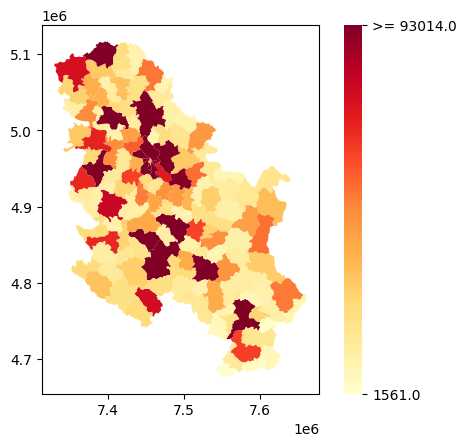

In [38]:
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 1)
cmap = 'YlOrRd'
# we leave the legend out
serbia_admin.plot(column='pop', cmap=cmap, norm = norm, ax=ax)

# we add the colorbar separately passing the norm and cmap
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax)
cbar.outline.set_visible(False)

# updating ticks VALUES
ticks = [norm.vmin, norm.vmax]
cbar.set_ticks(ticks = ticks)

# updating ticks LABELS
cbar.ax.set_yticklabels([round(t,1) for t in ticks])
cbar.ax.set_yticklabels([round(t,1) if t < norm.vmax else ">= "+str(round(t,1)) for t in cbar.ax.get_yticks()])

Above, we removed the outline of the color bar. Then we set the tick values to the min and the max population values, based on our norm object. Then, for the vmax value's label we added a ">=" to remind us that other, higher values are displayed with the darkest color.

### Varying alpha transparency based on an array
Finally, we can also convey variation in a continuos scale through transparency. `alpha` doesn't expect column names, so we cannot just pass the name of the column containing the variable. Instead we have to create an array from 0.0 to 1.0 values. To so we can a) use normalisation methods, or b) rescale the original values within 0 to 1 based on the original min and max values.

For example, with square root normalization:

In [39]:
# 1. Create an alpha array based on a normalized value (e.g., population)
import numpy as np
pop_max = serbia_admin['pop'].max()
alpha = np.sqrt(serbia_admin['pop'] / pop_max) 

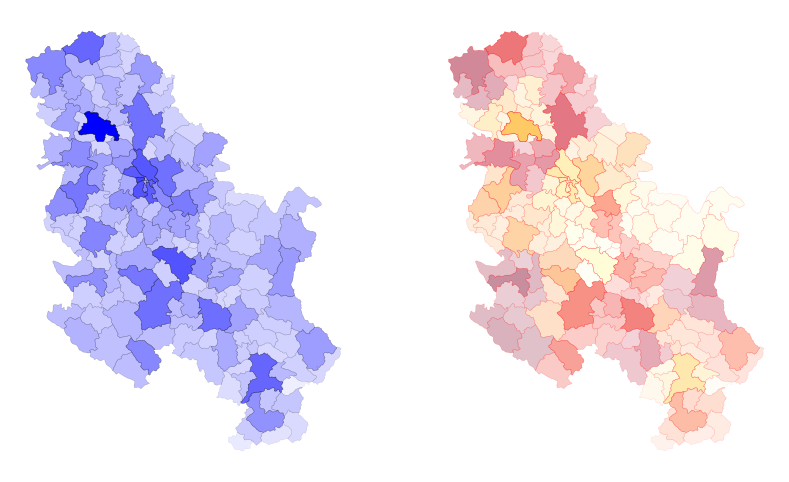

In [40]:
# Plot with varying alpha values
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
serbia_admin.plot(color = 'blue', ax=axes[0], alpha=alpha, edgecolor='black', linewidth = 0.3) #one color
serbia_admin.plot(cmap = 'YlOrRd', ax=axes[1], alpha=alpha, edgecolor='red', linewidth = 0.3) #cmap
for ax in axes:
    ax.set_axis_off()

<div class="alert alert-info" style="font-size:120%">

**Important**: <br>

`matplotlib` would not able to plot a color bar from variations in the alpha value since no column is passed directly. We would need, in this case, to build a color bar manually as demonstrated above.


## 2.7 Choropleth Maps for Categorical Variables
A choropleth for categorical variables assigns a different color to every potential value in the series based on certain colormaps (`cmap`).
We don't need to specify a scheme in this case, but just to the categorical `column`. Using last's week GeoDataFrame, we can plot terrorist attacks in Germany, for example, by group.

Text(0.5, 1.0, 'Terrorist Attacks in Germany, by Group')

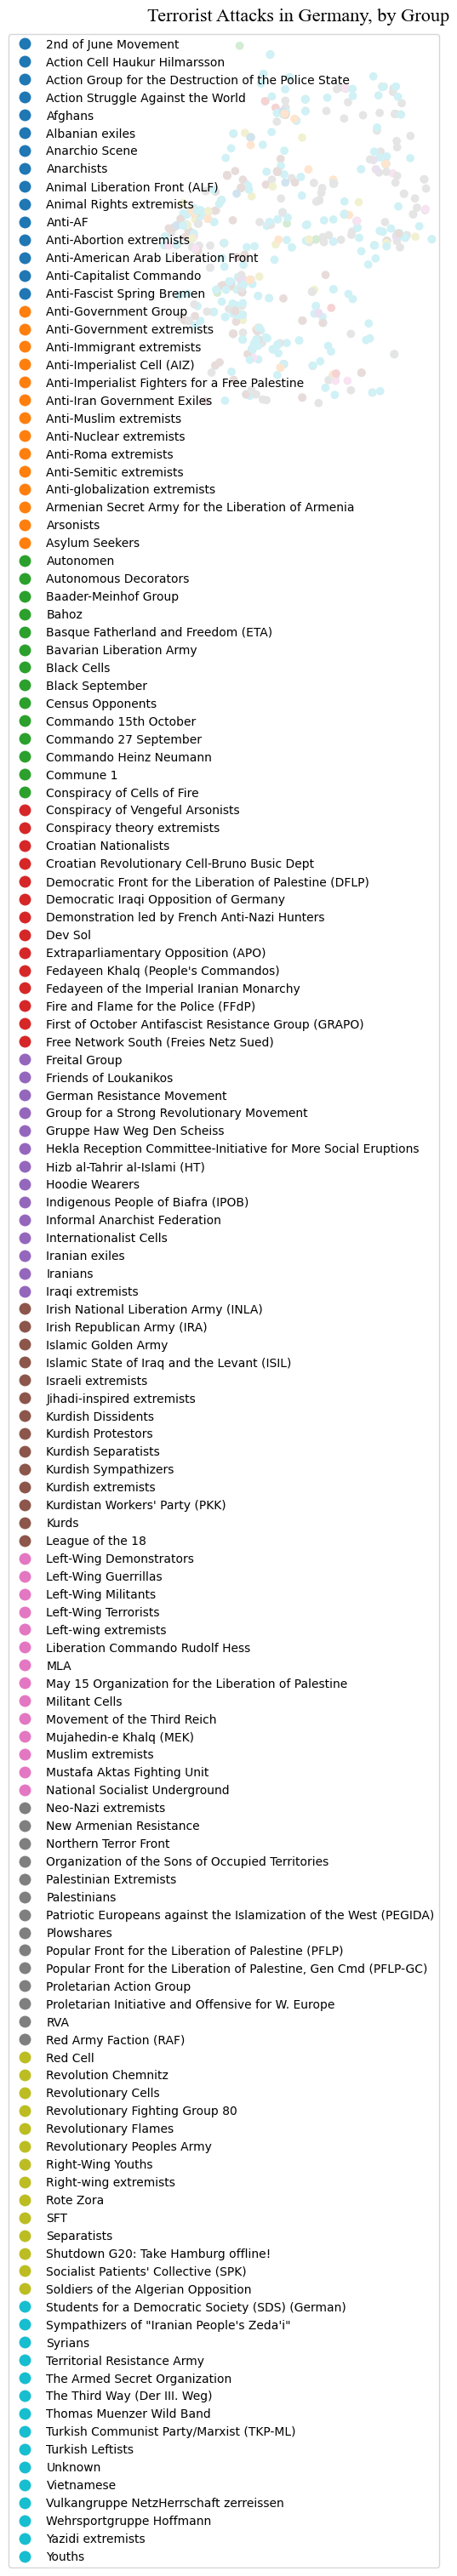

In [41]:
gdf = gpd.read_file("data/germany.shp").to_crs(germany_crs)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf.plot(ax = ax, column = 'gname', legend = True)
ax.set_axis_off()
title_parameters = {'fontsize':'16', 'fontname':'Times New Roman'}
ax.set_title("Terrorist Attacks in Germany, by Group", **title_parameters) #parameters as above

The map above is what you would get from datasets that are not cleaned/manipulated directly or when there are too many categories in the selected column. First, let's get a slimmer slice of the gdf that only contains attacks that cause a number of fatalies and wounded higher than 10.

In [42]:
condition = (gdf.nkill + gdf.nwound) > 10
gdf_filtered = gdf[condition].copy()

Then, let's build a function that creates a random color map based on the number of categories. This creates random `HUE`-based colors:

In [43]:
# Generate random colormap
def rand_cmap(nlabels):
    """ 
    It generates a categorical random color map, given the number of classes
    
    Parameters
    ----------
    nlabels: int
        The number of categories to be coloured.
    type_color: str {"soft", "bright"} 
        It defines whether using bright or soft pastel colors, by limiting the RGB spectrum.
       
    Returns
    -------
    cmap: matplotlib.colors.LinearSegmentedColormap
        The color map.
    """   
    # Generate color map for bright colors, based on hsv
    randHSVcolors = [(np.random.uniform(low=0.20, high=0.80),
                          np.random.uniform(low=0.20, high=0.80),
                          np.random.uniform(low=0.20, high= 0.80)) for i in range(nlabels)]

    random_colormap = LinearSegmentedColormap.from_list('new_map', randHSVcolors, N=nlabels)
   
    return random_colormap 

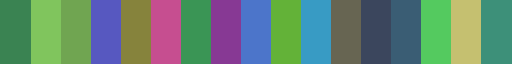

In [44]:
cmap = rand_cmap(len(gdf_filtered.gname.unique()))
cmap

We also place the legend on the center left. This is done automatically, but the legend and its items can be manipulated directly.
Legends in `matplotlib` are extremely complex to personalise. However, do have a look at https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html#matplotlib.pyplot.legend for both automatic and explicit manipulation.

In [45]:
legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5)}

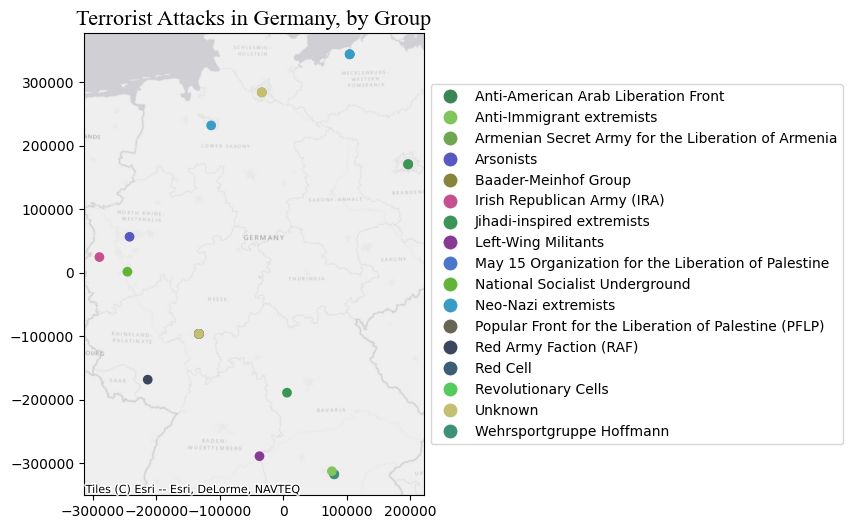

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf_filtered.plot(ax = ax, column = 'gname', legend = True, cmap = cmap, legend_kwds = legend_kwds)
title_parameters = {'fontsize':'16', 'fontname':'Times New Roman'}
ax.set_title("Terrorist Attacks in Germany, by Group", **title_parameters) #parameters as above
ctx.add_basemap(ax, crs= gdf_filtered.crs.to_string(), source = ctx.providers.Esri.WorldGrayCanvas)

We can also convey the impact of the events through the `markersize`. This introduces the concept of *cartogram* (see below).

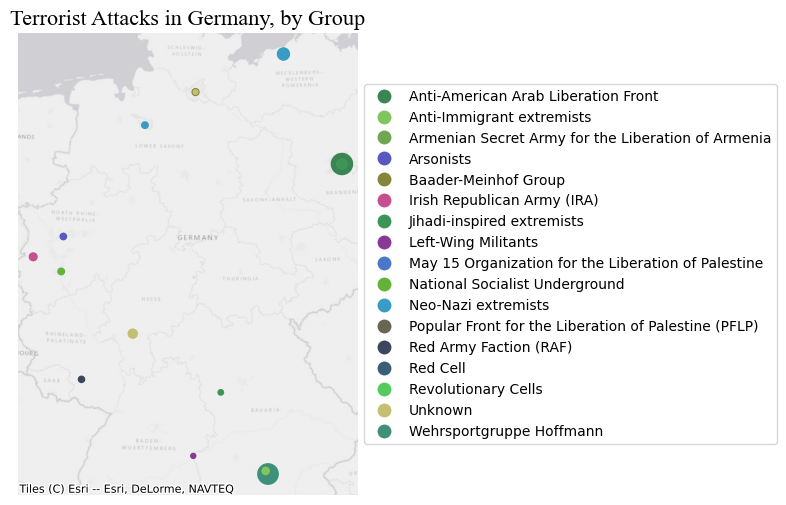

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf_filtered.plot(ax = ax, column = 'gname', markersize = 'nwound', legend = True, cmap = cmap, legend_kwds = legend_kwds)
ax.set_title("Terrorist Attacks in Germany, by Group", **title_parameters) #parameters as above
ctx.add_basemap(ax, crs= gdf_filtered.crs.to_string(), source = ctx.providers.Esri.WorldGrayCanvas)
ax.set_axis_off()

# Part III Cartograms: Using sizes for showing the magitude of a value 

[Cartograms](https://www.data-to-viz.com/graph/cartogram.html) are maps that represent the spatial distribution of a variable not by encoding it in a color palette but rather by modifying geographical objects. There are many algorithms to distort the shapes of geographical entities according to values, some of them incredibly complicated and complex. 

## 2.8 Polygons
You can obtain cartograms for `Polygon` with `geoplot`: see https://residentmario.github.io/geoplot/

`geoplot` functions pretty much work as `plot`

<GeoAxes: >

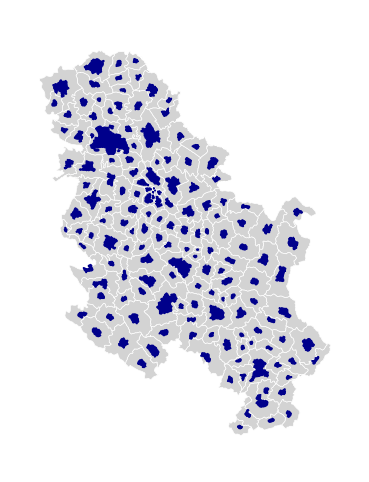

In [48]:
# this library needs the GeoDataFrame to be reverted to WGS
ax = gplt.cartogram(serbia_admin.to_crs(wgs), scale='pop', projection=gcrs.Mercator(), color = 'darkblue')
# see for projections that work with gplt https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
gplt.polyplot(serbia_admin.to_crs(wgs), facecolor='lightgray', edgecolor='white', ax=ax, lw = 0.5) # this is just for comparison

## 2.9 Points
For `Point` GeoDataFrames we can just go back to `plot` and pass a column name to `markersize`.

In [49]:
attacks = pd.read_csv("data/GTD_2022.csv", low_memory = False)
country = 'Germany'

df = attacks[attacks.country_txt == country].copy()
wgs = 'EPSG:4326'
germany_crs = 'EPSG:4839'
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = wgs)
gdf = gdf.to_crs(germany_crs)

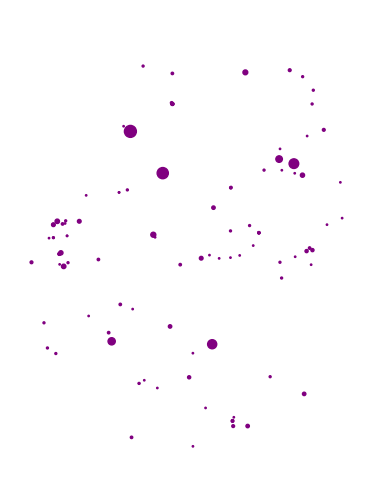

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf.plot(ax = ax, markersize = 'nwound', color = 'purple', legend = True)
ax.set_axis_off()

One can also convert convert polygons into points by using their centroids, and then define the size of the dot proportionally to the value of the variable we want to display.

## 2.10 LineString
For `LineString` we pass the column name to `linewidth`.  

Let's load a shapefile of lines. These lines represent frequnecy of train connections from/to train stations in the region of Liguria (Italy) to other stations within or outside the region. Each line refers to a connection between two specific stations, through a certain type of service and contains information about the frequency of that type of service. For example, the cities of Savona and Finale Ligure might be connected by 5 InterCity trains and 50 regional services. These services correspond to 2 different records.

In [51]:
trains_freq = gpd.read_file("data/trains_liguria.shp" )
trains_freq.crs

<Projected CRS: EPSG:3003>
Name: Monte Mario / Italy zone 1
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Italy - onshore and offshore - west of 12°E.
- bounds: (5.93, 36.53, 12.0, 47.04)
Coordinate Operation:
- name: Italy zone 1
- method: Transverse Mercator
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

Let's check the type of services contained here. 

In [52]:
trains_freq['train_type'].unique()

array(['REG', 'IC', 'FB', 'ICN', 'U', 'EC/EN', 'AV'], dtype=object)

We have:
- 'REG': regional trains.
- 'IC': intercity trains.
- 'FB': similar to IC, but slightly faster.
- 'ICN':  sleeper trains.
- 'U': urban trains (Genoa).
- 'EC/EN': international trains.
- 'AV': High-speed trains.

Let's keep just regional, intercity, and high-speed trains.

In [53]:
to_keep = ['REG', 'IC', 'AV']
trains_freq = trains_freq[trains_freq['train_type'].isin(to_keep)]

The usage of `linewdith` is a bit different from `markersize` for some reason. We have to pass an `array` of N values, where N is equal to the GeoDataFrame size. In other words, we have to pass the column we want to use to regulate the line width direclty as a list/array. Specifying the column name is not enough.

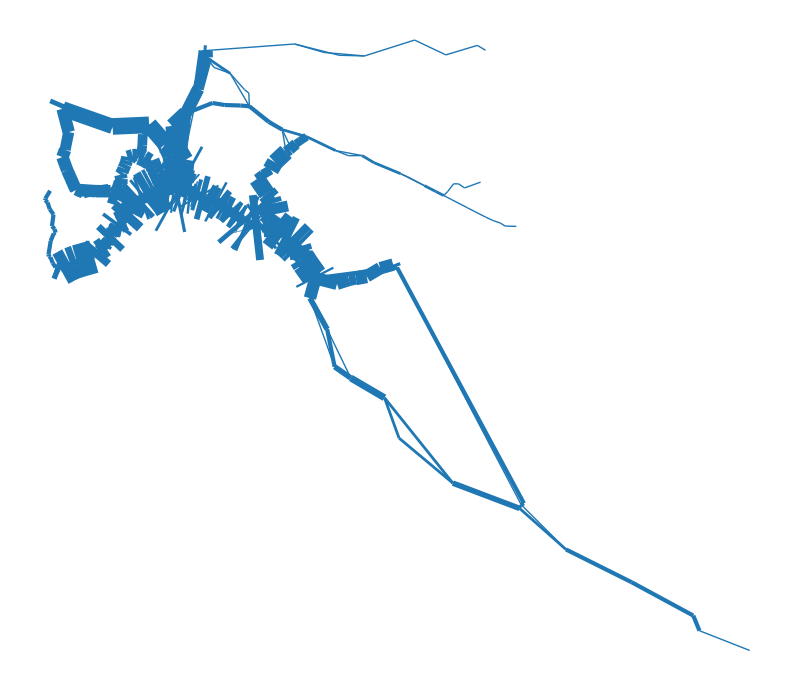

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
trains_freq.plot(ax = ax, linewidth = trains_freq['freq'])
ax.set_axis_off()

As you can see, the default arguments and simply passing the column values do not produce pretty results. 
The first thing to look at is the values that are passed to `linewidth`.  In some cases the min and max values, as well as their distribution, are not ideal for visually conveying the magnitude of the variable attached to the geometry. One option is to use a multiplier factor (see below), or to rescale the values from 0 to 1, for example, and then, again, if necessary use a multiplier.

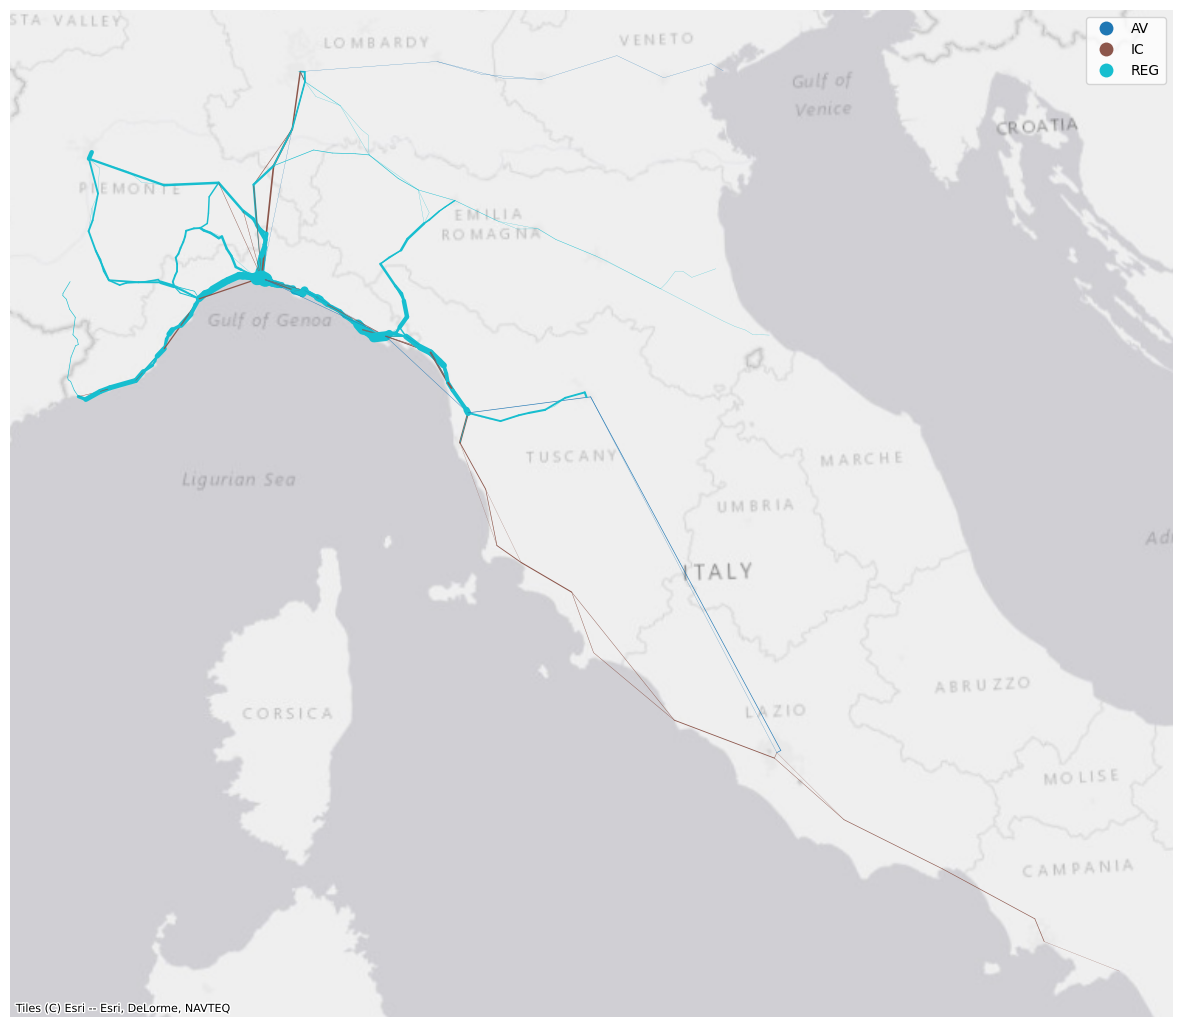

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 20))
lw = trains_freq['freq'] * 0.15
trains_freq.plot(ax = ax, linewidth = lw, capstyle = 'round', joinstyle = 'round', column = 'train_type', legend = True)
ctx.add_basemap(ax, crs= trains_freq.crs.to_string(), source = ctx.providers.Esri.WorldGrayCanvas)
ax.set_axis_off()

While this looks a bit better, this visualisation is not ideal because the frequencies are not snapped to the actual railway network. The lines represent instead connection between train stops and therefore their coordinatse only include the ones corresponding to the stations where the different services call at. Cne can devise approaches to:
- Assigning the frequencies, or any other value, to the corresponding infrastructure's section. For example, the railway section between two stations could be associated with a value representing the total number of REG services along it.
- Smoothing the lines representing the services by adding further coordinates along the line.

Both these processes go beyond the scopes of this lab and require several considerations depending on the data, the scale, and what information one wants to displays.

<div class="alert alert-success">

**Exercise**:

Today we've seen how to exploit matplotlib to plot GeoDataFrame. Go through the notebook again if you feel that there's something you need to review. You are not expected to remember each step/method/parameter. Rather, this notebook should be used as a reference from producing maps in python. Do keep in mind that most of the maps above have been produced with just a bunch of rows, so each of them can be improved and embellished with some more effort.

Now, if you are not overwhelmed, have a look at the very last map and produce some nice visualisation using the same data. You can further improve it clarity, add a legend that refers to the line width, visualise only a certain type of service, or add information/context, for example. In the folder '\data' you can also find a shapefile containing all the train stations in Italy, should you need that.

</div>

#### Saving figures (check [here for details](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html))

In [59]:
fig.savefig("fig1.pdf", dpi='figure', format="pdf", bbox_inches = 'tight')